In [1]:
import numpy as np
import pandas as pd
from scipy.stats import poisson, gamma, bernoulli
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier

%matplotlib inline

C:\Users\jakes\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
class naive_bayes:
    
    def __init__(self):
        self.num_classes = 2
        
    def fit(self,X,y):
        N = X.shape[0]
        D = X.shape[1]
        
        self.N_group = [np.sum(y==0),np.sum(y==1)]
        
        self.pi_hat = self.N_group[1]/N
        
        self.lam = np.empty(shape=(2,D))
        for i in range(self.num_classes):
            self.lam[i,:] = (np.sum(X[y==i,:],axis=0)+1) / (self.N_group[i] + 1)
    
    def predict(self,X):
        y_hat = np.zeros(shape=X.shape[0])
        y0 = np.sum(poisson.logpmf(X,np.expand_dims(self.lam[0,:],axis=0)),axis=1) + np.log(1-self.pi_hat)
        y1 = np.sum(poisson.logpmf(X,np.expand_dims(self.lam[1,:],axis=0)),axis=1) + np.log(self.pi_hat)
        y_hat[y1>y0] = 1 
        
        return y_hat
        
    def score_matrix(self,X,y):
        y_hat = self.predict(X)
        
        score = np.empty(shape=(self.num_classes,self.num_classes))
        for i in range(self.num_classes):
            for j in range(self.num_classes):
                score[i,j] = np.sum(y_hat[y==i]==j)
        
        return score

In [3]:
class KNN:
    def __init__(self):
        self.num_classes = 2
        self.distances = []
        
    def fit(self,X,y):
        self.X_train = X
        self.y_train = y
        
    def compute_distances(self,X):
        for i in range(X.shape[0]):
            distance = np.sum(np.abs(X[i,:]-self.X_train), axis=1)
            #distance = np.linalg.norm(X[i,:]-self.X_train, ord=1, axis=1)
            self.distances.append(distance)
        
    def predict(self,X,k):
        if not self.distances:
            self.compute_distances(X)
        
        y_hat = np.zeros(shape=X.shape[0])
        for i in range(X.shape[0]):
            k_closest = self.y_train[np.argpartition(self.distances[i], k)[:k]]
            
            if np.sum(k_closest)/k > .5:
                y_hat[i] = 1
            elif np.sum(k_closest)/k == .5:
                y_hat[i] = bernoulli.rvs(.5)
        return y_hat
        
    def score(self,X,y,k):
        y_hat = self.predict(X,k)
        
        score = np.empty(shape=(self.num_classes,self.num_classes))
        for i in range(self.num_classes):
            for j in range(self.num_classes):
                score[i,j] = np.sum(y_hat[y==i]==j)
                
        accuracy = (score[0,0] + score[1,1])/len(y)
        return accuracy

In [4]:
X = np.loadtxt('Bayes_classifier/X.csv', delimiter=',')
y = np.loadtxt('Bayes_classifier/y.csv', delimiter=',')

In [5]:
K = 10
batch_size = int(X.shape[0]/K)
np.random.seed(10)
permuted_index = np.random.permutation(X.shape[0])

In [6]:
score = np.zeros(shape=(2,2))
lambdas = np.zeros(shape=(2,X.shape[1]))

for i in range(K):
    test_index = permuted_index[(i*batch_size):((i+1)*batch_size)]
    train_index = np.concatenate((permuted_index[0:(i*batch_size)], permuted_index[((i+1)*batch_size):]))

    X_train = X[train_index,:]
    y_train = y[train_index]
    X_test = X[test_index,:]
    y_test = y[test_index]
    
    model = naive_bayes()
    model.fit(X_train,y_train)
    lambdas += model.lam
    score += model.score_matrix(X_test,y_test)
    
lambdas = lambdas/K

In [7]:
print(score)
print((score[0,0]+score[1,1])/4600)

[[2292.  495.]
 [  99. 1714.]]
0.8708695652173913


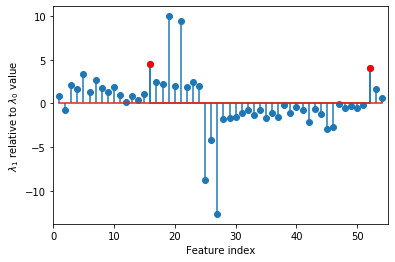

In [8]:
fig,ax = plt.subplots(1,1);
ax.stem(range(1,55),lambdas[1,:]-lambdas[0,:], use_line_collection=True);
ax.stem([16,52], [lambdas[1,15]-lambdas[0,15], lambdas[1,51]-lambdas[0,51]], use_line_collection=True, markerfmt='ro')
ax.set_xlabel('Feature index');
ax.set_ylabel('$\lambda_1$ relative to $\lambda_0$ value');
ax.set_xlim(0,55);
#plt.savefig('2_b.png');

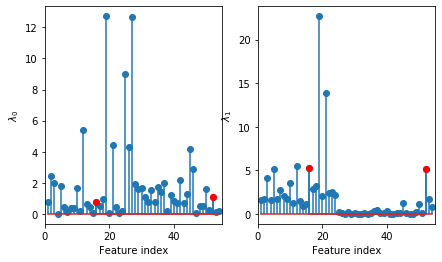

In [16]:
fig,ax = plt.subplots(1,2,figsize=(7,4));
ax[0].stem(range(1,55),lambdas[0,:], use_line_collection=True);
ax[0].stem([16,52], [lambdas[0,15], lambdas[0,51]], use_line_collection=True, markerfmt='ro')
ax[0].set_xlabel('Feature index');
ax[0].set_ylabel('$\lambda_0$');
ax[0].set_xlim(0,55);

ax[1].stem(range(1,55),lambdas[1,:], use_line_collection=True);
ax[1].stem([16,52], [lambdas[1,15], lambdas[1,51]], use_line_collection=True, markerfmt='ro')
ax[1].set_xlabel('Feature index');
ax[1].set_ylabel('$\lambda_1$');
ax[1].set_xlim(0,55);

plt.savefig('2_b_1.png');

In [ ]:
accuracies = np.zeros(shape=(20))

for i in range(K):
    test_index = permuted_index[(i*batch_size):((i+1)*batch_size)]
    train_index = np.concatenate((permuted_index[0:(i*batch_size)], permuted_index[((i+1)*batch_size):]))

    X_train = X[train_index,:]
    y_train = y[train_index]
    X_test = X[test_index,:]
    y_test = y[test_index]

    model = KNN()
    model.fit(X_train,y_train)

    for k in range(20):
        accuracies[k] += model.score(X_test,y_test,k+1)

accuracies = accuracies/K

In [ ]:
accuracies2 = np.empty(shape=(20))
for k in range(20):
    accuracy = 0
    for i in range(K):
        test_index = permuted_index[(i*batch_size):((i+1)*batch_size)]
        train_index = np.concatenate((permuted_index[0:(i*batch_size)], permuted_index[((i+1)*batch_size):]))

        X_train = X[train_index,:]
        y_train = y[train_index]
        X_test = X[test_index,:]
        y_test = y[test_index]

        model = KNeighborsClassifier(n_neighbors=k+1, metric='manhattan')
        model.fit(X_train,y_train)
        accuracy += model.score(X_test,y_test)
    
    accuracies2[k] = accuracy/K

In [ ]:
fig,ax = plt.subplots(1,1)
ax.plot(range(1,21),accuracies);
ax.set_xlabel('Number of neighbors');
ax.set_ylabel('Accuracy');
ax.set_xlim(1,20);
ax.set_xticks(range(1,21));
fig.tight_layout();
#plt.savefig('2_c.png');

In [ ]:
class gauss_process:
    def __init__(self, b=1, sigma2=1):
        self.b = b
        self.sigma2 = sigma2
        
    def kernel(self,x1,x2):
        return np.exp(-np.sum((x1-x2)**2)/self.b)
        
    def fit(self,X,y):
        self.N = X.shape[0]
        self.X_train = X
        self.y_train = y
        self.kernel_matrix = np.zeros(shape=(self.N,self.N))
        for i in range(self.N):
            for j in range(self.N-i):
                result = self.kernel(self.X_train[i,:], self.X_train[i+j,:])
                self.kernel_matrix[i,i+j] = result
                self.kernel_matrix[i+j,i] = result
        self.matrix_inv = np.linalg.inv(np.diag(np.ones(self.N)*self.sigma2) + self.kernel_matrix)
        self.mu_global_part = self.matrix_inv.dot(self.y_train)
    
    def mu(self,x):
        K_xD = np.empty(shape=self.N)
        for i in range(self.N):
            K_xD[i] = self.kernel(x, self.X_train[i,:])
        mu = K_xD.dot(self.mu_global_part)
        
        return mu
    
    def predict(self,X):
        y_hat = np.empty(shape=X.shape[0])
        for i in range(X.shape[0]):
            y_hat[i] = self.mu(X[i,:])
        
        return y_hat
        
    def score(self,X,y):
        y_hat = self.predict(X)
        
        return np.sqrt(np.sum((y-y_hat)**2)/len(y))

In [ ]:
X_train_G = np.loadtxt('Gaussian_process/X_train.csv',delimiter=',')
X_test_G = np.loadtxt('Gaussian_process/X_test.csv',delimiter=',')
y_train_G = np.loadtxt('Gaussian_process/y_train.csv',delimiter=',')
y_test_G = np.loadtxt('Gaussian_process/y_test.csv',delimiter=',')

In [ ]:
b_range = list(range(5,17,2))
sigma2_range = [x/10 for x in list(range(1,11))]
rmse_array = np.empty(shape=(len(sigma2_range), len(b_range)))

for i in range(len(sigma2_range)):
    for j in range(len(b_range)):
        gauss_model = gauss_process(b=b_range[j], sigma2=sigma2_range[i])
        gauss_model.fit(X_train_G,y_train_G)
        rmse_array[i,j] = gauss_model.score(X_test_G,y_test_G)

In [ ]:
np.round(rmse_array,3)

In [ ]:
gauss_model_small = gauss_process(b=5, sigma2=2)
gauss_model_small.fit(X_train_G[:,3:4],y_train_G)
y_hat = gauss_model_small.predict(X_train_G[:,3:4])

In [ ]:
fig,ax = plt.subplots(1,1);
ax.scatter(X_train_G[:,3:4], y_train_G, label='Actual response');
ax.plot(np.sort(X_train_G[:,3]), y_hat[np.argsort(X_train_G[:,3])], c='black', linewidth=4, label='Predictive mean');
ax.set_xlabel('Standardized car weight');
ax.set_ylabel('Standardized MPG');
ax.legend();
#plt.savefig('3_d.png');